# Tutorial  Outline

- [Introduction](#Introduction)
- [Preprerequisites](#Preprerequisites)
- [How does it work?](#How-does-it-work?)
- [Authentication](#Authentication)
 - [Authentication keys](#Authentication-keys)
- [MongoDB Collection](#MongoDB-Collection)
- [Starting a Stream](#Starting-a-Stream)
 - [Stream Listener](#Stream-Listener)
 - [Connect to a streaming API](#Connect-to-a-streaming-API)
- [Data Access and Analysis](#Data-Access-and-Analysis)
 - [Load results to a DataFrame](#Load-results-to-a-DataFrame)
- [Visualization](#Visualization)

# Introduction

Twitter provides two types of API to access their data:

- RESTful API: Used to get data about existing data objects like statuses "tweets", user, ... etc
- Streaming API: Used to get live statuses "tweets" as they are sent

The reason why you would like to use streaming API:

- Capture large amount of data because RESTful API has limited access to older data
- Real-time analysis like monitoring social discussion about a live event
- In house archive like archiving social discussion about your brand(s)
- AI response system for a twitter account like automated reply and filing questions or providing answers

# Preprerequisites

- Python 2 or 3
- Jupyter /w IPyWidgets
- Pandas
- Numpy
- Matplotlib
- MogoDB Installtion
- Pymongo
- Scikit-learn
- Tweepy
- Twitter account


# How does it work?

Twitter streaming API can provide data through a streaming HTTP response. This is very similar to downloading a file where you read a number of bytes and store it to disk and repeat until the end of file. The only difference is this stream is endless. The only things that could stop this stream are:

- If you closed your connection to the streaming response
- If your connection speed is not capable of receiving data and the servers buffer is filling up

This means that this process will be using the thread that it was launched from until it is stopped. In production, you should always start this in a different thread or process to make sure your software doesn't freeze until you stop the stream.

# Authentication

You will need four numbers from twitter development to start using streaming API. First, let's import some important libraries for dealing with twitter API, data analysis, data storage ... etc

In [1]:
import numpy as np
import pandas as pd
import tweepy
import matplotlib.pyplot as plt
import pymongo
import ipywidgets as wgt
from IPython.display import display
from sklearn.feature_extraction.text import CountVectorizer
import re
from datetime import datetime

%matplotlib inline

## Authentication keys

1. Go to https://apps.twitter.com/
2. Create an App (if you don't have one yet)
3. Grant read-only access to your account
4. Copy the four keys and paste them here:

In [2]:
api_key = "yP0yoCitoUNgD63ebMerGyJaE" # <---- Add your API Key
api_secret = "kLO5YUtlth3cd4lOHLy8nlLHW5npVQgUfO4FhsyCn6wCMIz5E6" # <---- Add your API Secret
access_token = "259862037-iMXNjfL8JBApm4LVcdfwc3FcMm7Xta4TKg5cd44K" # <---- Add your access token
access_token_secret = "UIgh08dtmavzlvlWWukIXwN5HDIQD0wNwyn5sPzhrynBf" # <---- Add your access token secret

auth = tweepy.OAuthHandler(api_key, api_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)

# MongoDB Collection

Connect to MongoDB and create/get a collection.

In [3]:
col = pymongo.MongoClient()["tweets"]["StreamingTutorial"]
col.count()

2251

# Starting a Stream

We need a listener which should extend `tweepy.StreamListener` class. There is a number of methods that you can extend to instruct the listener class to perform functionality. Some of the important methods are:

- `on_status(self, status)`: This will pass a status "tweet" object when a tweet is received
- `on_data(self, raw_data)`: Called when any any data is received and the raw data will be passed
- `on_error(self, status_code)`: Called when you get a response with code other than 200 (ok)

## Stream Listener

In [4]:
class MyStreamListener(tweepy.StreamListener):
    
    counter = 0
    
    def __init__(self, max_tweets=1000, *args, **kwargs):
        self.max_tweets = max_tweets
        self.counter = 0
        super().__init__(*args, **kwargs)
    
    def on_connect(self):
        self.counter = 0
        self.start_time = datetime.now()
    
    def on_status(self, status):
        # Increment counter
        self.counter += 1
        
        # Store tweet to MongoDB
        col.insert_one(status._json)
        
        
        if self.counter % 1 == 0:
            value = int(100.00 * self.counter / self.max_tweets)
            mining_time = datetime.now() - self.start_time
            progress_bar.value = value
            html_value = """<span class="label label-primary">Tweets/Sec: %.1f</span>""" % (self.counter / max([1,mining_time.seconds]))
            html_value += """ <span class="label label-success">Progress: %.1f%%</span>""" % (self.counter / self.max_tweets * 100.0)
            html_value += """ <span class="label label-info">ETA: %.1f Sec</span>""" % ((self.max_tweets - self.counter) / (self.counter / max([1,mining_time.seconds])))
            wgt_status.value = html_value
            #print("%s/%s" % (self.counter, self.max_tweets))
            if self.counter >= self.max_tweets:
                myStream.disconnect()
                print("Finished")
                print("Total Mining Time: %s" % (mining_time))
                print("Tweets/Sec: %.1f" % (self.max_tweets / mining_time.seconds))
                progress_bar.value = 0
                
    
myStreamListener = MyStreamListener(max_tweets=100)
myStream = tweepy.Stream(auth = api.auth, listener=myStreamListener)

## Connect to a streaming API

There are two methods to connect to a stream:

- `filter(follow=None, track=None, async=False, locations=None, stall_warnings=False, languages=None, encoding='utf8', filter_level=None)`
- `firehose(count=None, async=False)`

Firehose captures everything. You should make sure that you have connection speed that can handle the stream and you have the storage capacity that can store these tweets at the same rate. We cannot really use firehose for this tutorial but we'll be using `filter`.

You have to specify one of two things to filter:

- `follow`: A list of user ID to follow. This will stream all their tweets, retweets, and others retweeting their tweets. This doesn't include mentions and manual retweets where the user doesn't press the retweet button.
- `track`: A string or list of string to be used for filtering. If you use multiple words separated by spaces, this will be used for AND operator. If you use multiple words in a string separated by commas or pass a list of words this will be treated as OR operator.

**Note**: `track` is case insensitive.

### What to track?
I want to collect all tweets that contains any of these words:

- Jupyter
- Python
- Data Mining
- Machine Learning
- Data Science
- Big Data
- IoT
- #R

This could be done with a string or a list. It is easier to to it with a list to make your code clear to read.

In [5]:
keywords = ["Jupyter",
            "Python",
            "Data Mining",
            "Machine Learning",
            "Data Science",
            "Big Data",
            "DataMining",
            "MachineLearning",
            "DataScience",
            "BigData",
            "IoT",
            "#R",
           ]

# Visualize a progress bar to track progress
progress_bar = wgt.IntProgress(value=0)
display(progress_bar)
wgt_status = wgt.HTML(value="""<span class="label label-primary">Tweets/Sec: 0.0</span>""")
display(wgt_status)

# Start a filter with an error counter of 20
for error_counter in range(20):
    try:
        myStream.filter(track=keywords)
        print("Tweets collected: %s" % myStream.listener.counter)
        print("Total tweets in collection: %s" % col.count())
        break
    except:
        print("ERROR# %s" % (error_counter + 1))

Finished
Total Mining Time: 0:01:21.477351
Tweets/Sec: 1.2
Tweets collected: 100
Total tweets in collection: 2351


# Data Access and Analysis

Now that we have stored all these tweets in a MongoDB collection, let's take a look at one of these tweets

In [6]:
col.find_one()

{'_id': ObjectId('56937d2e105f1970314720e2'),
 'contributors': None,
 'coordinates': None,
 'created_at': 'Mon Jan 11 10:00:14 +0000 2016',
 'entities': {'hashtags': [{'indices': [22, 27], 'text': 'Rã®æ³•å‰‡'}],
  'symbols': [],
  'urls': [],
  'user_mentions': []},
 'favorite_count': 0,
 'favorited': False,
 'filter_level': 'low',
 'geo': None,
 'id': 686487772970942466,
 'id_str': '686487772970942466',
 'in_reply_to_screen_name': None,
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'is_quote_status': False,
 'lang': 'ja',
 'place': None,
 'retweet_count': 0,
 'retweeted': False,
 'source': '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
 'text': 'ä½“åŠ›è½ã¡ã¦ãã¦ãŠã°ã•ã‚“ã¿ãŸã„ã«ãªã£ã¦ããŸã€‚\n#Rã®æ³•å‰‡',
 'timestamp_ms': '1452506414059',
 'truncated': False,
 'user': {'contributors_enabled': False,
  'created_at': 'Tue Aug 18 16:19:16 +0000 

## Load results to a DataFrame

In [29]:
dataset = [{"created_at": item["created_at"],
            "text": item["text"],
            "user": "@%s" % item["user"]["screen_name"],
            "source": item["source"],
           } for item in col.find()]

dataset = pd.DataFrame(dataset)
dataset

,created_at,source,text,user
0,Mon Jan 11 10:00:14 +0000 2016,"<a href=""http://twitter.com/download/iphone"" r...",ä½“åŠ›è½ã¡ã¦ãã¦ãŠã°ã•ã‚“ã¿ãŸã„ã«ãªã£ã¦ããŸã€‚\n#Rã®æ³•å‰‡,@Q2HpiJwCX1huBwf
1,Mon Jan 11 10:09:26 +0000 2016,"<a href=""http://twitter.com/download/android"" ...",çš†ã«ãŠã°ã•ã‚“ã¨è¨€ã‚ã‚Œã¦ã†ã‚Œã—ãŒã£ã¦ã‚‹ #Rã®æ³•å‰‡,@Tamutamu1017
2,Mon Jan 11 10:00:10 +0000 2016,"<a href=""http://trendkeyword.blog.jp/"" rel=""no...",ã€R.I.Pã€‘æ€¥ä¸Šæ˜‡ãƒ¯ãƒ¼ãƒ‰ã€ŒR.I.Pã€ã®ã¾ã¨ã‚é€Ÿå ± https://t.co/yi1yfC...,@pickword_matome
3,Mon Jan 11 10:00:10 +0000 2016,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",#Rã®æ³•å‰‡ \nã©ã‚Œã‚‚ãŠã°ã•ã‚“è‡­ã„ã‘ã‚Œã©ã‚„ã£ã±ã‚Šé»„è‰²ãŒä¸€ç•ªã ãªã,@kakinotise
4,Mon Jan 11 10:00:10 +0000 2016,"<a href=""http://bufferapp.com"" rel=""nofollow"">...",The New Best Thing HP ATP - Vertica Big Data S...,@DataCentreNews1
5,Mon Jan 11 10:00:11 +0000 2016,"<a href=""http://dlvr.it"" rel=""nofollow"">dlvr.i...","IoT Now: lâ€™Internet of Things Ã¨ qui, ora https...",@datamanager_it
6,Mon Jan 11 10:00:11 +0000 2016,"<a href=""http://trendkeyword.doorblog.jp/"" rel...",ä»Šè©±é¡Œã®ã€ŒR.I.Pã€ã¾ã¨ã‚ https://t.co/VOc5cwK5hg #R.I.P ...,@buzz_wadai
7,Mon Jan 11 10:00:11 +0000 2016,"<a href=""http://twitterfeed.com"" rel=""nofollow...",#oldham #stockport VIDEO: Snake thief hides py...,@Labour_is_PIE
8,Mon Jan 11 10:00:11 +0000 2016,"<a href=""https://about.twitter.com/products/tw...",Las #startup pioneras de #machinelearning ofre...,@techreview_es
9,Mon Jan 11 10:00:12 +0000 2016,"<a href=""http://www.linkedin.com/"" rel=""nofoll...",Lets talk about how to harness the power of ma...,@jansmit1


## Checking the highest used words

In [30]:
cv = CountVectorizer()
count_matrix = cv.fit_transform(dataset.text)

word_count = pd.DataFrame(cv.get_feature_names(), columns=["word"])
word_count["count"] = count_matrix.sum(axis=0).tolist()[0]
word_count = word_count.sort_values("count", ascending=False).reset_index(drop=True)
word_count[:50]

,word,count
0,https,1986
1,co,1907
2,rt,804
3,de,550
4,rã®æ³•å‰‡,408
5,iot,374
6,the,358
7,bigdata,293
8,00,275
9,data,250


# Visualization

In [37]:
def get_source_name(x):
    value = re.findall(pattern="<[^>]+>([^<]+)</a>", string=x)
    if len(value) > 0:
        return value[0]
    else:
        return ""

Facebook                25
TweetDeck               37
RoundTeam               41
Hootsuite               46
twitterfeed             81
IFTTT                  134
dlvr.it                200
Twitter Web Client     388
Twitter for Android    392
Twitter for iPhone     515
Name: source, dtype: int64

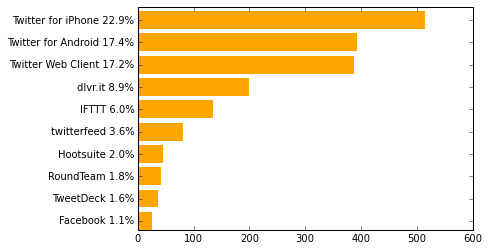

In [38]:
dataset.source_name = dataset.source.apply(get_source_name)

source_counts = dataset.source_name.value_counts().sort_values()[-10:]

bottom = [index for index, item in enumerate(source_counts.index)]
plt.barh(bottom, width=source_counts, color="orange", linewidth=0)

y_labels = ["%s %.1f%%" % (item, 100.0*source_counts[item]/len(dataset)) for index,item in enumerate(source_counts.index)]
plt.yticks(np.array(bottom)+0.4, y_labels)

source_counts